In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch.autograd.functional import hessian, jacobian

In [2]:
x = np.linspace(0,1,100, dtype=np.float)
t = np.linspace(0,1,100, dtype=np.float)
x, t = np.meshgrid(x, t) 
x = x.flatten()
t = t.flatten()
X = np.concatenate((x.reshape(-1,1), t.reshape(-1, 1)), axis=1)

num_points, input_dim = X.shape
hidden_neurons = 100
output_dim = 1

In [3]:
def g_trial(x, t, N):
    return (1 - t) * torch.sin(np.pi * x) + x * (1 - x) * t * N

#@torch.jit.script
def ode_loss(input_data, output_data):
    loss = 0
    
    for i in range(input_data.size(0)):
        Jx, Jt, Jn = jacobian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        Hx, Ht, Hn = hessian(g_trial, (input_data[i,0], input_data[i,1], output_data[i]),create_graph=True)
        loss = loss + (Jt - Hx[0]).pow(2)
    
    return loss / input_data.size(0)

#ode_loss_jit = torch.jit.script(ode_loss)
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.hessian
#u_hess = hessian(g_trial, (x, N))
# https://pytorch.org/docs/stable/autograd.html#torch.autograd.functional.hessian
#u_jacob = jacobian(g_trial, (x, N))

#torch.autograd.set_detect_anomaly(True)

dtype = torch.float
#device = torch.device("cuda:0")
device = torch.device("cpu")

x = torch.from_numpy(X)
x = x.to(dtype).to(device)
x.requires_grad = True

# Create random Tensors for weights.
w1 = torch.randn(input_dim, hidden_neurons, device=device, dtype=dtype, requires_grad=True)
w2 = torch.randn(hidden_neurons, output_dim, device=device, dtype=dtype, requires_grad=True)

In [4]:
learning_rate = 0.002
for epoch in range(10):
    N_output = F.relu(x.mm(w1)).mm(w2)
    
    # Compute and print loss
    loss = ode_loss(x, N_output)
    print(loss)
    
    #ode_loss(x, N_output)
    #print("loss = ",loss)
    # Use autograd to compute the backward pass.
    loss.backward()
    #torch.autograd.backward(loss)
    # Update weights using gradient descent
    with torch.no_grad():
        w1 -= learning_rate * w1.grad
        w2 -= learning_rate * w2.grad
        # Manually zero the gradients after updating weights
        w1.grad.zero_()
        w2.grad.zero_()

tensor([17.2830], grad_fn=<DivBackward0>)
tensor([11.5992], grad_fn=<DivBackward0>)
tensor([10.1624], grad_fn=<DivBackward0>)
tensor([9.7925], grad_fn=<DivBackward0>)
tensor([9.6910], grad_fn=<DivBackward0>)
tensor([9.6571], grad_fn=<DivBackward0>)
tensor([9.6403], grad_fn=<DivBackward0>)
tensor([9.6278], grad_fn=<DivBackward0>)
tensor([9.6165], grad_fn=<DivBackward0>)
tensor([9.6055], grad_fn=<DivBackward0>)


<ipython-input-5-b8ea6c900ba8>:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  cf = ax.pcolormesh(xp, tp, g, cmap=plt.get_cmap("inferno"))


Text(0, 0.5, '$t$')

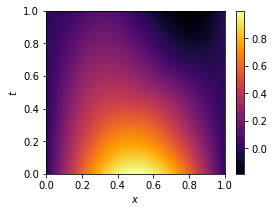

In [5]:
def g_trial_np(x, t, N):
    return (1 - t) * np.sin(np.pi * x) + x * (1 - x) * t * N

xp = np.linspace(0,1,100, dtype=np.float)
tp = np.linspace(0,1,100, dtype=np.float)
xp, tp = np.meshgrid(xp, xp) 

N_pred = F.relu(x.mm(w1)).mm(w2)
N_pred = N_pred.detach().numpy()
N_pred = N_pred.reshape(xp.shape)

g = g_trial_np(xp, tp, N_pred)

fig, ax = plt.subplots(figsize=(4, 3))
cf = ax.pcolormesh(xp, tp, g, cmap=plt.get_cmap("inferno"))
fig.colorbar(cf, ax=ax)
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

In [6]:
def f(x, t, N):
    return (x + t - N).mean()

x_test, y_test, N_test = (x[:, 0].reshape(-1,1), x[:, 1].reshape(-1,1), N_output)
dx, dt, dN = jacobian(f, (x[:, 0].reshape(-1,1), x[:, 1].reshape(-1,1), N_output))
print(dt)

tensor([[1.0000e-04],
        [1.0000e-04],
        [1.0000e-04],
        ...,
        [1.0000e-04],
        [1.0000e-04],
        [1.0000e-04]])


In [7]:
dx, dt, dN = hessian(f, (x[:, 0].reshape(-1, 1), x[:, 1].reshape(-1, 1), N_output))
#print(dx[0][0])

In [8]:
dx, dt, dN = torch.autograd.grad([f(x_test, y_test, N_test)], [x_test, y_test, N_test])

In [9]:
x1 = torch.linspace(0,1, 10, requires_grad=True)
x2 = torch.linspace(0,1, 10, requires_grad=True)
z = torch.sin(x1) * torch.cos(x2)

print(z)
torch.autograd.grad(z, [x1, x2])

tensor([0.0000, 0.1102, 0.2150, 0.3092, 0.3882, 0.4481, 0.4860, 0.4999, 0.4893,
        0.4546], grad_fn=<MulBackward0>)


RuntimeError: grad can be implicitly created only for scalar outputs

In [ ]:
import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

xt = tf.convert_to_tensor(X, dtype="float32")

class ODE_FFNN(tf.keras.Model):
    def __init__(self):
        super(ODE_FFNN, self).__init__()
        self.input_layer = tf.keras.layers.Dense(2)
        self.hidden_layer = tf.keras.layers.Dense(10, activation='relu')
        self.output_layer = tf.keras.layers.Dense(1)
        return
        
    def call(self, input_tensor, training=True):
        x = self.input_layer(input_tensor, training=training)
        x = self.hidden_layer(x, training=training)
        x = self.output_layer(x, training=training)
        return x
    
def g_trial(x, t, N):
    x, t, = xt[:, 0], xt[:, 1]
    x = tf.reshape(x, shape=(-1,1))
    t = tf.reshape(t, shape=(-1,1))
    #print(N(xt).shape)
    #print(x.shape)
    #print(t.shape)
    return (1 - t) * tf.sin(np.pi * t) + x * (1 - x) * t * N


    
def cost_func(x, nn):
    return tf.reduce_mean(x, axis=0)
    
nn = ODE_FFNN()

#print(nn(xt).shape)
print("->", g_trial(xt, nn).shape)

print(tf.hessians(ys = g_trial(xt, nn), xs = xt))

#cost_func(xt, nn)